### Unidad 2: Taller de análisis de datos textuales

<h1> Notebook 2 - Topic Modeling</h1>

- El modelamiento de tópicos (__Topic Modeling__) es una técnica para extraer automáticamente los tópicos ocultos de grandes volúmenes de texto. Esta técnica busca responder a la pregunta: ¿cuáles son los tópicos que se hablan en un conjunto de textos?

- __Latent Dirichlet Allocation__ (LDA) es un algoritmo popular para _topic modeling_ con buenas implementaciones en el paquete Gensim de Python. 

- Un desafío metodológico consiste en extraer __tópicos coherentes y significativos__. Esto depende en gran medida de la calidad del preprocesamiento del texto y de la estrategia de __encontrar el número óptimo de tópicos__. Este taller propone abordar algunas buenas prácticas para resolver estos problemas.

El taller tiene 2 partes, una parte guiada que ilustra cómo utilizar LDA para extraer tópicos en un dataset de discusiones de foros. La segundo parte es un trabajo práctico que apunta a reproducir una metodología de extracción de tópicos con LDA.

## Parte I - ¿Cómo aplicar LDA para extraer tópicos de un dataset de textos?

### 1. Introducción

Una de las principales aplicaciones del procesamiento del lenguaje natural es extraer automáticamente los temas o tópicos que la gente está discutiendo de grandes volúmenes de texto. Algunos ejemplos de textos de gran tamaño podrían ser feeds de medios sociales, reseñas de clientes de hoteles, películas, etc., feedbacks de usuarios, noticias, correos electrónicos de quejas de clientes, etc.

Saber de qué habla la gente y comprender sus problemas y opiniones es muy valioso para las empresas, los administradores y las campañas políticas. Y es realmente difícil leer manualmente volúmenes tan grandes y compilar los temas.

Por lo tanto, se requiere un algoritmo automatizado que pueda leer los documentos de texto y generar automáticamente los tópicos tratados.

En este taller, tomaremos un ejemplo real del conjunto de datos de '20 Newsgroups' (foros de discusiones en inglés) y usaremos el algoritmos LDA para extraer los tópicos discutidos.

Usaremos el paquete Latent Dirichlet Allocation (LDA) de Gensim. También extraeremos el volumen y la contribución porcentual de cada tema para tener una idea de lo importante que es un tema.

## 2. Prerrequisitos y librerías necesarias - Descargar una lista de Stop-Word en inglés disponibles en el paquete NLTK

Necesitaremos las palabras stop-words definidas en NLTK y también el modelo spacy para el procesamiento, en particular la lematización, del inglés.

In [1]:
import nltk; nltk.download('stopwords')

import spacy

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luciano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Los paquetes principales utilizados en este taller son _re_ (expresión regular), gensim, spacy y pyLDAvis. Además de esto también usaremos matplotlib, numpy y pandas para el manejo y visualización de datos.

Importamos los paquetes:

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Luciano\Anaconda3\envs\base_datos\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 3. ¿Qué hace LDA?

El enfoque de LDA para el _Topic modeling_ es que considera cada documento como una colección de tópicos en una cierta proporción. Y cada tópico como una colección de palabras claves, de nuevo, en una cierta proporción.

Una vez que uno proporciona el algoritmo con el número de temas, todo lo que hace es reorganizar la distribución de tópicos dentro de los documentos y la distribución de palabras claves dentro de los tópicos para obtener una buena composición de la distribución de tópicos y palabras clave.

Cuando hablamos de __tópico__, ¿qué es realmente y cómo se representa?

Un tópico no es más que un conjunto de palabras claves dominantes que son típicas de un tema dado. Con sólo mirar las palabras claves, puede identificar de qué se trata el tema.

Por ejemplo, el tópico formado por las palabras: 'Sánchez', 'copa, 'ganar', 'Alexis', probablemente se refieren a un tópico que tiene que ver con el équipo chileno de fútbol.

### 4. Importar el dataset

Para este ejercicio utilizaremos el conjunto de datos de los 20 foros en inglés '20-Newsgroup'. Esta versión del conjunto de datos contiene unos 11.000 mensajes de grupos de noticias de 20 temas diferentes. Está disponible como newsgroups.json.

Esto se importa usando pandas.read_json y el conjunto de datos resultante tiene 3 columnas como se muestra.

Para reducir el tiempo de proceso, reduciremos el dataset a 1.000 mensajes.

In [3]:
# Import Dataset
df = pd.read_json('newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [4]:
df=df.head(1000)

### 5. Preparar las palabras Stop-Words y filtrar emails

Ya hemos descargado las palabras clave. Importémoslos y hagámoslos disponibles en la variable stop_words.

Como pueden ver, en el dataset hay muchos correos electrónicos, líneas nuevas y espacios adicionales que distraen bastante. Deshagámonos de ellos usando expresiones regulares y stop-words específicos.

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


Después de eliminar los correos electrónicos y los espacios adicionales, el texto sigue pareciendo desordenado. No está listo para que el LDA lo consuma. Necesitamos tokenizar y lematizar cada frase.

### 6. Tokenizar en palabras y limpieza

Vamos a convertir cada frase en una lista de palabras, eliminando los signos de puntuación y los caracteres innecesarios por completo.

El <code>simple_preprocess()</code> de Gensim es comodo para esto.

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


### 7. Creación de modelos Bigram y Trigram

Los bigramas son dos palabras que aparecen frecuentemente juntas en el documento. Los trigramas son 3 palabras que ocurren con frecuencia.

Algunos ejemplos en nuestro ejemplo son: 'front_bumper', 'oil_leak', 'maryland_college_park' etc.

Gensim puede construir e implementar los bigrams, trigramas, cuadrantes y más. Los dos argumentos importantes para las Frases son min_count y threshold. Cuanto más altos sean los valores de estos parámetros, más difícil será que las palabras se combinen con bigrams.

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Luciano\Anaconda3\envs\base_datos\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac', 'wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### 9. Eliminar Stop-words, generar bigrams y lemmatizar

El modelo bigrams está listo. Vamos a definir las funciones para eliminar los stop-words, hacer bigrams y lemmatización y llamarlas secuencialmente.

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Llamamos a la funciones en el orden:

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['wheres', 'thing', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'looked', 'latir', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'please', 'mail', 'brought', 'neighborhood', 'lerxst']]


## 10. Crear el diccionario y el corpus necesarios para el modelo de tópicos

Las dos entradas principales al modelo de tópicos de LDA son el diccionario (id2word) y el corpus. Vamos a crearlos.

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)]]


Gensim crea un identificador único para cada palabra del documento. El corpus producido que se muestra arriba es un mapeo de (word_id, word_frequency).

Por ejemplo, (0, 1) arriba implica que la palabra id 0 ocurre una vez en el primer documento. Del mismo modo, la palabra id 1 aparece dos veces y así sucesivamente.

Esto es usado como entrada por el modelo LDA.

Si desea ver a qué palabra corresponde un id dado, pase el id como una llave al diccionario.

In [12]:
id2word[0]

'addition'

O bien, puede ver una forma legible por el ser humano del propio corpus.

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('brought', 1),
  ('bumper', 1),
  ('called', 1),
  ('car', 4),
  ('college', 1),
  ('could', 1),
  ('day', 1),
  ('door', 1),
  ('doors', 1),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('latir', 1),
  ('lerxst', 1),
  ('lines', 1),
  ('looked', 1),
  ('made', 1),
  ('mail', 1),
  ('maryland', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp', 1),
  ('organization', 1),
  ('park', 1),
  ('please', 1),
  ('posting', 1),
  ('production', 1),
  ('rac', 1),
  ('really', 1),
  ('rest', 1),
  ('saw', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('wam', 1),
  ('whatever', 1),
  ('wheres', 1),
  ('wondering', 1),
  ('years', 1)]]

### 11. Construyendo el modelo de tópicos

Tenemos todo lo necesario para entrenar el modelo LDA. Además del corpus y el diccionario, también debemos proporcionar el número de tópicos esperados (veremos en secciones ulteriores cómo estimar el mejor número de tópicos).

_chunksize_ es el número de documentos que se utilizarán en cada chunk de entrenamiento. _update_every_ determina la frecuencia con la que se deben actualizar los parámetros del modelo y pasa es el número total de pases de entrenamiento.

El proceso de entramiento del modelo de tópicos puede demorar unos minutos:

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## 12. Ver los tópicos del modelo LDA

El modelo LDA anterior está construido con 10 tópicos diferentes donde cada tópico es una combinación de palabras claves y cada palabra clave contribuye con un cierto peso al tema.

Puede ver las palabras clave para cada tema y el peso (importancia) de cada palabra clave usando lda_model.print_topics() como se muestra a continuación.

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=20))
doc_lda = lda_model[corpus]

[(0,
  '0.006*"wings" + 0.006*"wide" + 0.005*"study" + 0.005*"hockey" + '
  '0.005*"window" + 0.004*"santo" + 0.004*"cleveland" + 0.004*"event" + '
  '0.004*"goal" + 0.004*"april" + 0.004*"leafs" + 0.004*"douglas" + '
  '0.004*"roger" + 0.004*"anderson" + 0.003*"doug" + 0.003*"st" + '
  '0.003*"testing" + 0.003*"air" + 0.003*"gary" + 0.003*"reservar"'),
 (1,
  '0.025*"lines" + 0.023*"organization" + 0.014*"posting" + 0.013*"writes" + '
  '0.013*"university" + 0.012*"host" + 0.012*"nntp" + 0.008*"would" + '
  '0.008*"article" + 0.008*"new" + 0.008*"like" + 0.007*"distribution" + '
  '0.005*"computer" + 0.005*"know" + 0.005*"reply" + 0.005*"im" + 0.005*"usar" '
  '+ 0.004*"anyone" + 0.004*"one" + 0.004*"want"'),
 (2,
  '0.014*"would" + 0.009*"god" + 0.007*"think" + 0.007*"people" + '
  '0.007*"believe" + 0.006*"dont" + 0.005*"us" + 0.005*"like" + 0.005*"first" '
  '+ 0.005*"may" + 0.004*"must" + 0.004*"know" + 0.004*"said" + 0.004*"also" + '
  '0.004*"one" + 0.004*"true" + 0.003*"made" +

__¿Cómo interpretar esto?__

El tópico 7 se representa como _0.018 "game" + 0.017 "team" + 0.012 "play" + 0.012 "win" + 0.011 "year" + 0.011 "hockey" + 0.010 "player", etc.

Las ponderaciones reflejan la importancia de una palabra clave para ese tema.

Mirando estas palabras clave, ¿puedes adivinar cuál podría ser este tema? --> campeonato de hockey norte-americano.

Del mismo modo, ¿puede repasar las palabras claves de cada tópico evaluar cuál es el tópico?

## 13. Calcular las métricas de perplejidad y coherencia de los tópicos

Las métricas de __perplejidad del modelo__ y la __coherencia de los tópicos__ proporcionan una medida para evaluar qué tan bueno es un modelo de tópico dado.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.951710485237841

Coherence Score:  0.4377635267882152


### 14. ¿Cómo encontrar el número óptimo de tópicos ?

El enfoque clásico para encontrar el número óptimo de tópicos consiste en construir muchos modelos LDA con diferentes valores de número de tópicos (k) y elegir el que dé el valor de coherencia más alto.

La elección de una "k" que marca el final de un rápido crecimiento de la coherencia temática suele ofrecer temas significativos e interpretables. Escoger un valor aún mayor puede a veces proporcionar subtópicos más granulares.

Si ve que las mismas palabras clave se repiten en varios temas, es probable que sea una señal de que la 'k' es demasiado grande.

Los valores de compute_coherence_values() (ver abajo) entrena múltiples modelos LDA y proporciona los modelos y sus correspondientes puntuaciones de coherencia.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Entrenar los distintos modelos puede necesitar varios minutos:

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

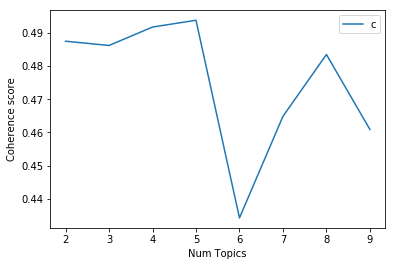

In [20]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4875
Num Topics = 3  has Coherence Value of 0.4862
Num Topics = 4  has Coherence Value of 0.4918
Num Topics = 5  has Coherence Value of 0.4938
Num Topics = 6  has Coherence Value of 0.4342
Num Topics = 7  has Coherence Value of 0.4649
Num Topics = 8  has Coherence Value of 0.4835
Num Topics = 9  has Coherence Value of 0.4609


Si el puntaje de coherencia parece seguir aumentando, puede tener más sentido elegir el modelo que dio el puntaje más alto antes de aplanarse. Este es exactamente el caso aquí.

Así que para los pasos siguientes voy a elegir el modelo con 20 temas en sí.

In [22]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.006*"people" + 0.005*"would" + 0.005*"writes" + 0.004*"lines" + '
  '0.004*"dont" + 0.004*"timar" + 0.004*"organization" + 0.004*"like" + '
  '0.003*"even" + 0.003*"think"'),
 (1,
  '0.014*"lines" + 0.013*"organization" + 0.008*"posting" + 0.007*"university" '
  '+ 0.006*"host" + 0.006*"nntp" + 0.006*"writes" + 0.005*"would" + '
  '0.005*"like" + 0.004*"key"'),
 (2,
  '0.014*"god" + 0.006*"would" + 0.005*"people" + 0.004*"believe" + '
  '0.004*"think" + 0.004*"bible" + 0.003*"dont" + 0.003*"must" + 0.003*"know" '
  '+ 0.003*"space"'),
 (3,
  '0.006*"writes" + 0.006*"organization" + 0.006*"lines" + 0.005*"would" + '
  '0.004*"year" + 0.004*"people" + 0.004*"first" + 0.004*"runs" + '
  '0.004*"article" + 0.004*"dont"'),
 (4,
  '0.009*"_" + 0.006*"file" + 0.005*"entry" + 0.004*"cx" + 0.003*"copiar" + '
  '0.003*"vs" + 0.003*"monitor" + 0.003*"ir" + 0.003*"st" + 0.002*"ide"')]


### 16. Encontrar el tópico dominante en cada frase o documento

Una de las aplicaciones prácticas del modelo de tópicos es determinar de qué tópico trata un documento dado.

Para encontrar eso, encontramos el número del tópico que tiene el porcentaje más alto de contribución en ese documento.

La función format_topics_sentences() agrega esta información en una tabla presentable.

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #row = sorted(row, key=lambda x: (x[1]), reverse=True)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9086,"lines, organization, posting, university, host...",From: (wheres my thing) Subject: WHAT car is t...
1,1,1.0,0.3896,"lines, organization, posting, university, host...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,0.0,0.5020,"people, would, writes, lines, dont, timar, org...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,1.0,0.9894,"lines, organization, posting, university, host...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,1.0,0.9711,"lines, organization, posting, university, host...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,1.0,0.4672,"lines, organization, posting, university, host...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,1.0,0.8298,"lines, organization, posting, university, host...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,1.0,0.9864,"lines, organization, posting, university, host...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,3.0,0.9456,"writes, organization, lines, would, year, peop...",Subject: Re: Dont more innocents die without t...
9,9,0.0,0.4111,"people, would, writes, lines, dont, timar, org...",From: (Jon Livesey) Subject: Re: Genocide is C...


### 17. Encontrar el documento más representativo para cada tópico

A veces las palabras claves del tópico pueden no ser suficientes para entender de qué se trata el tema. Por lo tanto, para ayudar a comprender el tópico, se puede encontrar los documentos a los que un tópico dado ha contribuido más y deducir el tema leyendo ese documento.

In [24]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9757,"people, would, writes, lines, dont, timar, org...",From: (Serdar Argic) Subject: Traditional and ...
1,1.0,0.9918,"lines, organization, posting, university, host...",From: (Richard Gooch) Subject: Re: Animation w...
2,2.0,0.8750,"god, would, people, believe, think, bible, don...",From: (Cardinal Ximenez) Subject: Re: The arro...
3,3.0,0.9613,"writes, organization, lines, would, year, peop...",From: (Henry Spencer) Subject: Re: Lunar Colon...
4,4.0,0.9992,"_, file, entry, cx, copiar, vs, monitor, ir, s...",Subject: roman.bmp 01/14In response to the req...


### 18. Distribución de tópicos en el dataset

Finalmente, queremos entender el volumen y la distribución de los tópicos para juzgar la amplitud de la discusión. La siguiente tabla expone esa información.

In [25]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1.0,"lines, organization, posting, university, host...",183.0,0.183
1,1.0,"lines, organization, posting, university, host...",507.0,0.507
2,0.0,"people, would, writes, lines, dont, timar, org...",106.0,0.106
3,1.0,"lines, organization, posting, university, host...",179.0,0.179
4,1.0,"lines, organization, posting, university, host...",25.0,0.025
5,1.0,"lines, organization, posting, university, host...",NaN,NaN
6,1.0,"lines, organization, posting, university, host...",NaN,NaN
7,1.0,"lines, organization, posting, university, host...",NaN,NaN
8,3.0,"writes, organization, lines, would, year, peop...",NaN,NaN
9,0.0,"people, would, writes, lines, dont, timar, org...",NaN,NaN


## II - Trabajo práctico

La carpeta Drive siguiente contiene una serie de datasets: https://drive.google.com/drive/folders/14bt3oF4tibthkxQee0-a_esveoPwrZtd?usp=sharing

Cada dataset contiene noticias de prensa publicadas por medios chilenos entre Febrero 2017 y Febrero 2018. Cada dataset fue generado buscando una palabra clave específica, por ejemplo :'feminismo', 'corrupción', 'educación', 'mapuche', 'tecnología', etc.

El trabajo práctico consiste en:
- seleccionar 1 dataset. Por ejemplo: 'tecnología'
- aplicar una metodología basada en LDA para conocer cuáles son los tópicos conversados por los medios cuándo se habla de 'tecnología'. 

In [26]:
import nltk; nltk.download('stopwords')

import spacy

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luciano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [29]:
df = pd.read_csv('MAD_libertad1.csv',sep='|',error_bad_lines=False,header=None)
df.head()

,0,1,2,3
0,2017-05-17 12:59:27,ElPeriodista,El Periodista – Locales » Corte concede liber...,"Santiago, 17 may (Sputnik).- La justicia otor..."
1,2017-06-01 09:33:08,EstrelladeArica,Favor le costó a mujer estar 7 meses recluida...,09:10 Fue detenida en Chacalluta con 7 kilos ...
2,2017-05-10 12:01:21,biobio,Justicia ordena al Servel y Gendarmería estab...,La Corte Suprema acogió dos nuevos recursos d...
3,2017-03-02 19:17:05,estrellachiloe,Carabineros frustró robo a las oficinas de En...,18:50 Uno de los delincuentes fue capturado e...
4,2017-02-27 08:15:56,Cooperativa,[Opinión] - Claudia Honorato - Cuando la libe...,Dichoso es quien conoce el verdadero valor de...


In [30]:
df=df.head(1000)

In [31]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [33]:
data = df[3].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' Santiago, 17 may (Sputnik).- La justicia otorgó este miércoles el beneficio '
 'de libertad condicional a Sergio Apablaza Rozas, que cumple su condena en el '
 'Penal Punta Peuco, junto a otros exuniformados que cometieron crímenes de '
 'lesa humanidad durante la dictadura de Augusto Pinochet. “La Comisión de '
 'Libertad Condicional de la Corte de Apelaciones de Santiago concedió la '
 'solicitud solo a un interno, de los quince condenados por diversas causas de '
 'violaciones a los derechos humanos de Punta Peuco que la habían pedido”, '
 'señaló el portal electrónico Emol. Esta medida se aplicó al general retirado '
 'de Carabineros Sergio Apablaza Rozas, penado a 5 años y un día de cárcel por '
 'su participación en la detención y desaparición del opositor al régimen '
 'Pedro Juan Merino Molina. Apablaza ingresó a Punta Peuco, ubicado a las '
 'afueras de Santiago, el 21 de enero de 2015, y debía permanecer en el '
 'recinto hasta 2020. En su informe de excarcelación, se espe

In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['santiago', 'may', 'sputnik', 'la', 'justicia', 'otorgo', 'este', 'miercoles', 'el', 'beneficio', 'de', 'libertad', 'condicional', 'sergio', 'apablaza', 'rozas', 'que', 'cumple', 'su', 'condena', 'en', 'el', 'penal', 'punta', 'peuco', 'junto', 'otros', 'exuniformados', 'que', 'cometieron', 'crimenes', 'de', 'lesa', 'humanidad', 'durante', 'la', 'dictadura', 'de', 'augusto', 'pinochet', 'la', 'comision', 'de', 'libertad', 'condicional', 'de', 'la', 'corte', 'de', 'apelaciones', 'de', 'santiago', 'concedio', 'la', 'solicitud', 'solo', 'un', 'interno', 'de', 'los', 'quince', 'condenados', 'por', 'diversas', 'causas', 'de', 'violaciones', 'los', 'derechos', 'humanos', 'de', 'punta', 'peuco', 'que', 'la', 'habian', 'pedido', 'senalo', 'el', 'portal', 'electronico', 'emol', 'esta', 'medida', 'se', 'aplico', 'al', 'general', 'retirado', 'de', 'carabineros', 'sergio', 'apablaza', 'rozas', 'penado', 'anos', 'un', 'dia', 'de', 'carcel', 'por', 'su', 'participacion', 'en', 'la', 'detencion', 'd

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Luciano\Anaconda3\envs\base_datos\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['santiago', 'may', 'sputnik', 'la', 'justicia', 'otorgo', 'este', 'miercoles', 'el', 'beneficio', 'de', 'libertad', 'condicional', 'sergio', 'apablaza', 'rozas', 'que', 'cumple', 'su', 'condena', 'en', 'el', 'penal', 'punta_peuco', 'junto', 'otros', 'exuniformados', 'que', 'cometieron', 'crimenes', 'de', 'lesa_humanidad', 'durante', 'la', 'dictadura', 'de', 'augusto', 'pinochet', 'la', 'comision', 'de', 'libertad', 'condicional', 'de', 'la', 'corte', 'de', 'apelaciones', 'de', 'santiago', 'concedio', 'la', 'solicitud', 'solo', 'un', 'interno', 'de', 'los', 'quince', 'condenados', 'por', 'diversas', 'causas', 'de', 'violaciones', 'los', 'derechos_humanos', 'de', 'punta_peuco', 'que', 'la', 'habian', 'pedido', 'senalo', 'el', 'portal', 'electronico', 'emol', 'esta', 'medida', 'se', 'aplico', 'al', 'general', 'retirado', 'de', 'carabineros', 'sergio', 'apablaza', 'rozas', 'penado', 'anos', 'un', 'dia', 'de', 'carcel', 'por', 'su', 'participacion', 'en', 'la', 'detencion', 'desaparicion',

In [36]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [37]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['santiago', 'may', 'sputnik', 'justicia', 'otorgar', 'miercoles', 'beneficiar', 'libertar', 'condicional', 'sergio', 'apablaza', 'rozar', 'cumplir', 'condenar', 'penal', 'punta', 'peuco', 'juntar', 'exuniformados', 'cometer', 'crimenes', 'leso', 'humanidad', 'dictadura', 'augusto', 'pinochet', 'comision', 'libertar', 'condicional', 'cortar', 'apelación', 'santiago', 'concedio', 'solicitud', 'solo', 'internar', 'condenar', 'causar', 'violación', 'derecho', 'humano', 'punta', 'peuco', 'habian', 'pedir', 'senalo', 'portal', 'electronico', 'emol', 'medir', 'aplicar', 'general', 'retirar', 'carabinero', 'sergio', 'apablaza', 'rozar', 'penar', 'ano', 'carcel', 'participacion', 'detencion', 'desaparicion', 'opositor', 'regimen', 'pedro', 'juan', 'merino', 'molina', 'apablaza', 'ingresar', 'punta', 'peuco', 'ubicar', 'aforar', 'santiago', 'enero', 'debia', 'permanecer', 'recinto', 'informar', 'excarcelacion', 'especificar', 'recluso', 'cumplia', 'condicionar', 'optar', 'libertar', 'condicion

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 4), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 2), (45, 1), (46, 2), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 4), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 2), (93, 3), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 3)

In [39]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acogio', 1),
  ('ademar', 1),
  ('aforar', 1),
  ('agente', 1),
  ('alemán', 1),
  ('ano', 1),
  ('apablaza', 3),
  ('aparecio', 1),
  ('apelación', 2),
  ('aplicar', 1),
  ('asentar', 1),
  ('augusto', 1),
  ('beneficiar', 1),
  ('bueno', 1),
  ('carabinero', 2),
  ('carcel', 1),
  ('casar', 1),
  ('casi', 1),
  ('causar', 1),
  ('centrar', 1),
  ('chile', 1),
  ('ciudad', 1),
  ('clandestino', 1),
  ('colonia', 2),
  ('colono', 1),
  ('cometer', 1),
  ('comision', 2),
  ('comunista', 1),
  ('concedio', 1),
  ('conclave', 1),
  ('condenar', 2),
  ('condicional', 4),
  ('condicionar', 1),
  ('conducir', 1),
  ('coronel', 1),
  ('cortar', 2),
  ('creer', 1),
  ('crimenes', 1),
  ('cumplia', 1),
  ('cumplir', 1),
  ('debia', 1),
  ('derecho', 1),
  ('desaparicion', 2),
  ('detencion', 2),
  ('detener', 2),
  ('dictador', 1),
  ('dictadura', 2),
  ('dignidad', 2),
  ('direccion', 1),
  ('electronico', 1),
  ('emol', 1),
  ('encubrir', 1),
  ('enero', 1),
  ('epoca', 1),
  ('equivaler'

In [40]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=20))
doc_lda = lda_model[corpus]

[(0,
  '0.045*"ciudad" + 0.041*"newsletter" + 0.022*"terminos" + 0.022*"elegir" + '
  '0.022*"recibir" + 0.021*"mundo" + 0.021*"chile" + 0.021*"futuro" + '
  '0.021*"valor" + 0.021*"querer" + 0.021*"sitiar" + 0.021*"emol" + '
  '0.021*"condicionar" + 0.021*"anunciar" + 0.021*"suceder" + '
  '0.021*"propiedad" + 0.020*"suscribete" + 0.020*"pronto" + 0.020*"soychile" '
  '+ 0.020*"recibiras"'),
 (1,
  '0.023*"libertar" + 0.014*"ano" + 0.009*"hombre" + 0.009*"chileno" + '
  '0.008*"esperar" + 0.006*"dejar" + 0.006*"realizar" + 0.006*"foto" + '
  '0.006*"pasar" + 0.006*"partir" + 0.005*"luego" + 0.005*"nuevo" + '
  '0.005*"tribunal" + 0.005*"ingresar" + 0.004*"july" + 0.004*"detenido" + '
  '0.004*"sujeto" + 0.004*"leer" + 0.004*"condenar" + 0.004*"agenciar"'),
 (2,
  '0.030*"libertar" + 0.010*"venezuela" + 0.009*"chile" + 0.009*"presidente" + '
  '0.008*"pinera" + 0.008*"democracia" + 0.008*"decir" + 0.007*"gobernar" + '
  '0.006*"ex" + 0.006*"venezolano" + 0.006*"contar" + 0.006*"pais" +

In [42]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.272067430388702

Coherence Score:  0.4942700751751337


In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [44]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

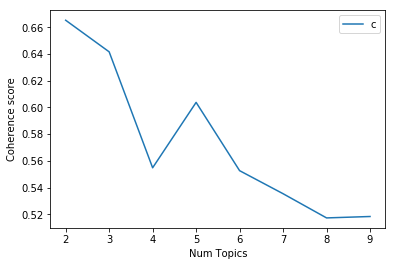

In [45]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6653
Num Topics = 3  has Coherence Value of 0.6417
Num Topics = 4  has Coherence Value of 0.5548
Num Topics = 5  has Coherence Value of 0.6038
Num Topics = 6  has Coherence Value of 0.5526
Num Topics = 7  has Coherence Value of 0.5353
Num Topics = 8  has Coherence Value of 0.5172
Num Topics = 9  has Coherence Value of 0.5183
